In [1]:
import pandas as pd
import numpy as np
import simulations.gbm as sim
import matplotlib.pyplot as plt
import seaborn

seaborn.set()

Following dataset has entries for 4 nearest delivery months for WTI oil

In [2]:
raw_data = pd.read_excel("PET_PRI_FUT_S1_D.xls", sheet_name=1, header=2)
# also at https://www.eia.gov/dnav/pet/xls/PET_PRI_FUT_S1_D.xls
raw_data.tail()

,Date,"Cushing, OK Crude Oil Future Contract 1 (Dollars per Barrel)","Cushing, OK Crude Oil Future Contract 2 (Dollars per Barrel)","Cushing, OK Crude Oil Future Contract 3 (Dollars per Barrel)","Cushing, OK Crude Oil Future Contract 4 (Dollars per Barrel)"
9288,2020-03-24,24.01,26.20,28.05,29.30
9289,2020-03-25,24.49,27.16,29.19,30.46
9290,2020-03-26,22.60,25.71,28.27,29.85
9291,2020-03-27,21.51,25.15,28.13,30.05
9292,2020-03-30,20.09,24.09,27.40,29.56


In [3]:
# set date as index for this time series
raw_data = raw_data.set_index("Date")

For nearest 1 month calendar spread, contract 1 and contract 2 has to be used. For May 2020, the option expiration is 20 April 2020 (day before the nearest of the two futures contracts expires), current calendar is available [here](https://www.cmegroup.com/trading/energy/crude-oil/light-sweet-crude_product_calendar_options.html?optionProductId=2952&optionExpiration=2952-K0#optionProductId=2952).  
The value of a calendar spread is for call (FC1-FC2-S)*1000 or 0 if it is negative. FC1 and FC2 are settlement prices when the option expires.

In [4]:
selected = raw_data.loc["2015-01-01":, raw_data.columns[0]:raw_data.columns[1]].copy()
selected.columns = ["Contract 1", "Contract 2"]
selected.tail()

,Contract 1,Contract 2
Date,,
2020-03-24,24.01,26.20
2020-03-25,24.49,27.16
2020-03-26,22.60,25.71
2020-03-27,21.51,25.15
2020-03-30,20.09,24.09


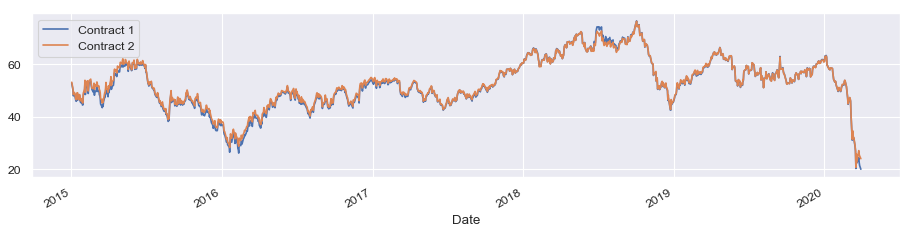

In [5]:
plt.figure(figsize=(14, 3), dpi= 80)
for col in selected.columns:
    selected[col].plot(legend=True)
plt.show()

In [6]:
logs = np.log(selected/selected.shift(1))
logs = logs.dropna()

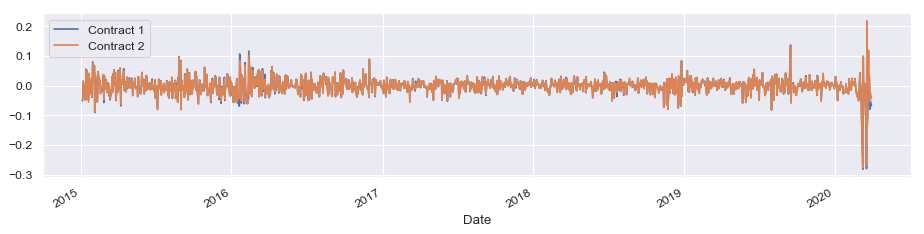

In [7]:
plt.figure(figsize=(14, 3), dpi= 80)
for col in logs.columns:
    logs[col].plot(legend=True)
plt.show()

When using two different products, it is necessary to include their correlation into simulation, so that the simulated prices move like in real life. Since both timeseries are futures on the same commodity and the only difference is their settlement date, the correlation is very close to 1. (following three lines of code show how to compute correlation in python using numpy)

In [8]:
corres1 = np.corrcoef(logs[logs.columns[0]],logs[logs.columns[1]])
cor1 = corres1[1,0]
cor1

0.9906418530514763

In [9]:
import scipy.stats as sps
from pandas.tseries.offsets import BDay
logs = logs.asfreq(BDay())
logs = logs.fillna(method='ffill').dropna()
logs

,Contract 1,Contract 2
Date,,
2015-01-05,-0.051603,-0.049996
2015-01-06,-0.043081,-0.041631
2015-01-07,0.014910,0.012713
2015-01-08,0.002874,0.004067
2015-01-09,-0.008852,-0.005902
...,...,...
2020-03-24,0.027445,0.027866
2020-03-25,0.019794,0.035986
2020-03-26,-0.080315,-0.054865


## Calendar spread simulation

Function simulates paths with a GBM model. Random noise is generated from normal distribution, the time gap is assumed to be 1 day, so delta t is 1.

In [10]:

def owner_position(flag: str) -> int:
    if flag == "c":
        return 1
    elif flag == "p":
        return -1
    else:
        raise ValueError(f"Position can be either p or c, not {positionFlag}")
        
def prepare_data(data):
    if not isinstance(data, pd.DataFrame):
        raise ValueError("The input should be timeseries in pandas DataFrame")
    data = data.squeeze()
    data = data.asfreq(BDay())
    data = data.fillna(method='ffill').dropna()
    return data
    
def change_to_logrets(data):
    rets = (data/data.shift(1))
    rets = rets.dropna()
    lrets = np.log(rets)
    return lrets

def calendar_spread_gbm(
            data,*,
            strike,
            position_flag,
            maturity=1,
            steps,
            simulations,
            discount_rate,
            history_length=None,
            ):
    """
    Function to simulate paths and calculate option price of a calendar spread option
    
    data should be a dataframe with two columns that contain historical data
    """

    data1 = prepare_data(data)
   # data2 = prepare_data(data2)
    
    initial_price1 = data1.iloc[-1,0]
    initial_price2 = data1.iloc[-1,1]
   # initial_price2 = data2[-1]

    if history_length == None:
        history_data1 = data1
       # history_data2 = data2
    else:
        history_data1 = data1[-history_length:]
       # history_data2 = data2[-history_length:]
        
    lrets = change_to_logrets(history_data1)
    # fit normal distribution, scale is std
    loc_d1, scale_d1 = sps.norm.fit(lrets[lrets.columns[0]])
    print(loc_d1, "//1//",scale_d1)
    
    loc_d2, scale_d2 = sps.norm.fit(lrets[lrets.columns[1]])
    print(loc_d2, "//2//",scale_d2)
    
    cor = np.corrcoef(logs[logs.columns[0]],logs[logs.columns[1]])[1,0]
    print(f"corr coef: {cor}")
    
    sum = 0.0
    paths1 = []
    paths2 = []

    sim_range = range(1,simulations+1)
    step_range = range(1,steps+1)

    for _ in sim_range:
        path1 = [initial_price1]
        path2 = [initial_price2]
        st1 = initial_price1
        st2 = initial_price2
        for _ in step_range:
            # GMB model with normal distribution
            noise1 = sps.norm.rvs(loc=0,scale=1)
            ds1 = st1 * (loc_d1 + scale_d1 * noise1)
            st1 = st1 + ds1
            path1.append(st1)
            
            noise2 = ( cor * noise1 ) + ( sps.norm.rvs(loc=0,scale=1) * np.sqrt(1-cor**2) )
            ds2 = st2 * (loc_d2 + scale_d2 * noise2)
            st2 = st2 + ds2
            path2.append(st2)
            
        # option payoff calculation
        # https://www.cmegroup.com/content/dam/cmegroup/rulebook/NYMEX/3/397.pdf
        if position_flag == "c":
            payoff = max(((st1-st2) - strike), 0)
        elif position_flag == "p":
            payoff = max((strike - (st2-st1)), 0)
        else:
            raise ValueException("Position can be either 'p' for put or 'c' for call")
            
        sum = sum + payoff
        paths1.append(path1)
        paths2.append(path2)
    print(sum)
    return (np.exp(-discount_rate*maturity)/simulations)*sum, [paths1,paths2], range(0,steps+1)

### Estimate the discount rate

One part of an option's price is it's time value. After performing a simulation to estimate the option's final value, it is necessary to transform that value into a present one. That is done by discounting the value at expiration by a risk free rate. There are multiple possibilites from which risk free rate can be chosen:
 * Domestic risk free rates (Treasury bills, bonds or notes) [Risk free rates in wacc calculation](http://www.eru.cz/documents/10540/5475589/Navrh-zasad-cenove-regulace-2021-2025-pro-verejnou-konzultaci.pdf/f6df3fd5-d5af-425f-a53f-ecbddd4447fe)
 * Interest rates (LIBOR, PRIBOR)
 
Considering the Czech Republic, PRIBOR seems like the best best choice since it is regularly [updated](https://www.cnb.cz/en/financial-markets/money-market/pribor/fixing-of-interest-rates-on-interbank-deposits-pribor/) and offers several term options (1 month up to 1 year) to choose from, which is convenient for option pricing (unless it's an option that expires in a distant future, in that case bonds would be more suitable). [Emission of treasury bills](https://www.mfcr.cz/cs/verejny-sektor/rizeni-statniho-dluhu/emise-statnich-dluhopisu/emisni-kalendare-spp/2020/emisni-kalendar-statnich-pokladnicnich-p-37569) is less frequent with lower selection of due dates.  
<br>
In the following simulation, 1 month PRIBOR rate (1.04%) is used for `discount_rate`. Since the function expects year value, I will multiply the PRIBOR 1 month rate by 12, this is offseted by using 1/12 for the `maturity` parameter.

### Simulation

1 month calendar spread put option, strike is set to 0.1 dollars per barrel, maturity is in one month.

In [11]:
strike = 0.3 # in USD per barrel, arbitrarily chosen
discount_rate = 0.0104 * 12 # chosen discount rate
maturity = 1.0/12.0 # value of 1 means one year so 1/12th is one month
steps = 16
simulations = 500
position_flag = "p" # simulate for call option
history_size = 50

price, paths, step_range = calendar_spread_gbm(
    selected, # timeseries of futures price is inputted
    strike=strike,
    position_flag=position_flag,
    maturity=maturity,
    steps=steps,
    simulations=simulations,
    discount_rate=discount_rate,
    history_length=history_size,
    )

-0.021756444604341483 //1// 0.07349188883152369
-0.018064827526514046 //2// 0.07487021625711777
corr coef: 0.9907925345237846
0.0


Price:  0.0
Contract unit price:  0.0


<Figure size 1120x240 with 0 Axes>

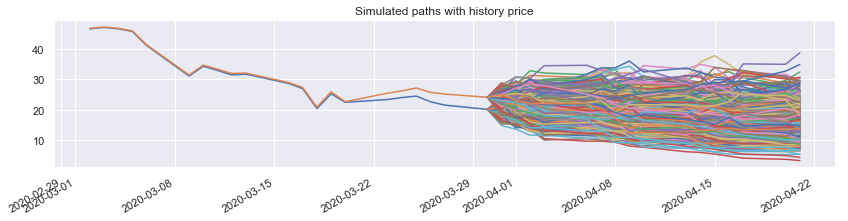

In [12]:
import matplotlib.dates as mdates
print("Price: ", price)
print("Contract unit price: ", price * 1000)
plt.figure(figsize=(14, 3), dpi= 80, facecolor='w', edgecolor='k')
previous_part = selected.loc["2020-03-01":]
sim_dates = pd.bdate_range(start=selected.index[-1],periods=len(step_range))
start_d = previous_part.index[0]
end_d = sim_dates[-1]

fig, ax = plt.subplots(1, 1, figsize=(14,3))
ax.set_title("Simulated paths with history price")
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.plot(previous_part)
for path in paths[0]:
    ax.plot(sim_dates, path)
for path in paths[1]:
    ax.plot(sim_dates, path)
fig.autofmt_xdate()
plt.show()

The contract is more closely described [here](https://www.cmegroup.com/content/dam/cmegroup/rulebook/NYMEX/3/397.pdf) and current info about price and volumes are [here](https://www.cmegroup.com/trading/energy/crude-oil/light-sweet-crude_contractSpecs_options.html?optionProductId=2952&optionExpiration=2952-K0#optionProductId=2952).

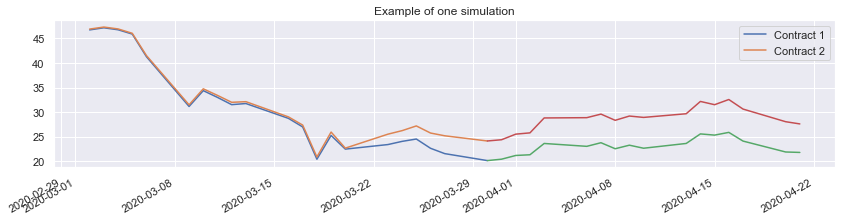

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(14,3))
ax.set_title("Example of one simulation")
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')

for col in previous_part.columns:
    ax.plot(previous_part[col], label=col)
ax.plot(sim_dates, paths[0][0])
ax.plot(sim_dates, paths[1][0])
fig.autofmt_xdate()
plt.legend()
plt.show()